# MATH50003 Numerical Analysis: Problem Sheet 6

This problem sheet explores condition numbers, indefinite integration,
and Euler's method.

Questions marked with a ⋆ are meant to be completed without using a computer.

In [1]:
using LinearAlgebra, Plots, QuadGK

## 1. Condition numbers


**Problem 1.1⋆** Prove that, if $|ϵ_i| ≤ ϵ$ and $n ϵ < 1$, then
$$
\prod_{k=1}^n (1+ϵ_i) = 1+θ_n
$$
for some constant $θ_n$ satisfying $|θ_n| ≤ {n ϵ \over 1-nϵ}$.

**Problem 1.2⋆** Let $A,B ∈ ℝ^{m × n}$. Prove that if the columns satisfy $\|𝐚_j\|_2 ≤ \| 𝐛_j\|_2$ then
$\|A\|_F ≤ \|B\|_F$ and $\|A \|_2 ≤ \sqrt{\hbox{rank}(B)} \|B\|_2$.

**Problem 1.3⋆** Compute the 1-norm, 2-norm, and ∞-norm condition numbers for the following matrices:
$$
\begin{bmatrix}
1 & 2 \\ 3 & 4
\end{bmatrix}, \begin{bmatrix}
1/3 & 1/5 \\ 0 & 1/7
\end{bmatrix}, \begin{bmatrix} 1 \\ & 1/2 \\ && ⋯ \\ &&& 1/2^n \end{bmatrix}
$$
(Hint: recall that the singular values of a matrix $A$ are the square roots of the eigenvalues of the Gram matrix
$A^⊤A$.)


**Problem 1.4**
State a bound on the relative error on $A 𝐯$ for $\|𝐯\|_2 = 1$ for the following matrices:
$$
\begin{bmatrix}
1/3 & 1/5 \\ 0 & 1/10^3
\end{bmatrix},
 \begin{bmatrix} 1 \\ & 1/2 \\ && ⋯ \\ &&& 1/2^{10} \end{bmatrix}
$$
Compute the relative error in computing $A 𝐯$ (using `big` for a high-precision version to compare against)
where $𝐯$ is the last column of $V$ in the SVD $A = U Σ V^⊤$, computed using the `svd` command with
`Float64` inputs. How does the error compare to the predicted error bound?

In [2]:
A = [1/3 1/5
     0 1/10^3]
bigA = [big(1/3) big(1/5)
        big(0) big(1/10^3)]
sing = svd(A)
v = sing.S
Av = A * v
print(bigA*v-Av)

BigFloat[1.168561267220606885350739552044710994225143119923684650093148595928482791350689e-19, -4.567732937384597376209562959739109796005671095629896771915350039972025797396782e-23]

## 2. Indefinite integration

**Problem 2.1** Implement backward differences to approximate
indefinite-integration. How does the error compare to forward
and mid-point versions  for $f(x) = \cos x$ on the interval $[0,1]$?
Use the method to approximate the integrals of
$$
\exp(\exp x \cos x + \sin x), \prod_{k=1}^{1000} \left({x \over k}-1\right), \hbox{ and } f^{\rm s}_{1000}(x)
$$
to 3 digits, where $f^{\rm s}_{1000}(x)$ was defined in PS2.

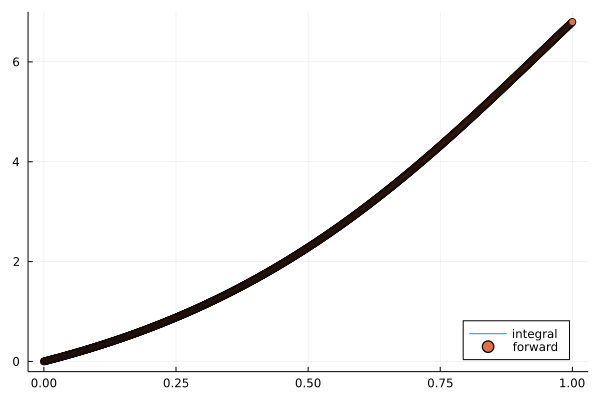

In [3]:
function indefint(x)
    h = step(x) # x[k+1]-x[k]
    n = length(x)
    L = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
end

n = 1000
x = range(0, 1; length=n)
L = indefint(x)
m = (x[1:end-1] + x[2:end])/2 # midpoints

c = 0 # u(0) = 0
f = x -> exp(exp(x) * cos(x) + sin(x))
𝐟ᶠ = f.(x[2:end])
𝐮ᶠ = L \ [c; 𝐟ᶠ]
integral = zeros(n)
for (index, value) in enumerate(x)
    if value != 0
        integral[index] = quadgk(f, Float64(0), Float64(value))[1]
    end
end
    
plot(x, integral; label="integral", legend=:bottomright)
scatter!(x, 𝐮ᶠ; label="forward")

**Problem 2.2** Implement indefinite-integration 
where we take the average of the two grid points:
$$
{u'(x_{k+1}) + u'(x_k) \over 2} ≈ {u_{k+1} - u_k \over h}
$$
What is the observed rate-of-convergence using the ∞-norm for $f(x) = \cos x$
on the interval $[0,1]$?
Does the method converge if the error is measured in the $1$-norm?

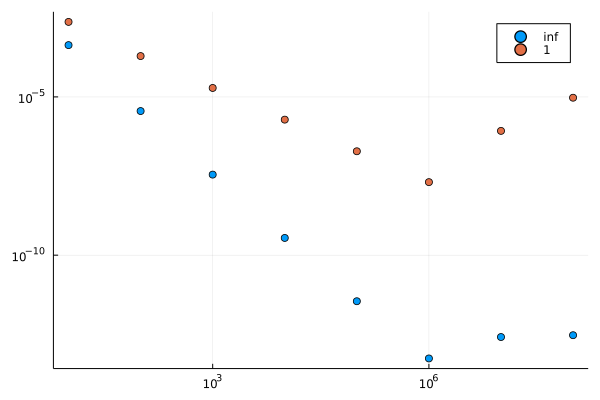

In [5]:
function mid_err1(u, c, f, n)
    x = range(0, 1; length = n)
    m = (x[1:end-1] + x[2:end]) / 2 # midpoints
    uᵐ = indefint(x) \ [c; f.(m)]
    norm(uᵐ - u.(x), Inf)
end

function mid_err2(u, c, f, n)
    x = range(0, 1; length = n)
    m = (x[1:end-1] + x[2:end]) / 2 # midpoints
    uᵐ = indefint(x) \ [c; f.(m)]
    norm(uᵐ - u.(x), 1)
end

f = x -> cos(x)
ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, mid_err1.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="inf")
scatter!(ns, mid_err2.(sin, 0, f, ns); label="1")

## 3. Euler methods

**Problem 3.1** Solve the following ODEs 
using forward and/or backward Euler and increasing $n$, the number of time-steps, 
until $u(1)$ is determined to 3 digits:
$$
\begin{align*}
u(0) &= 1, u'(t) = \cos(t) u(t) + t \\
v(0) &= 1, v'(0) = 0, v''(t) = \cos(t) v(t) + t \\
w(0) &= 1, w'(0) = 0, w''(t) = t w(t) + 2 w(t)^2
\end{align*}
$$
If we increase the initial condition $w(0) = c > 1$, $w'(0)$
the solution may blow up in finite time. Find the smallest positive integer $c$
such that the numerical approximation suggests the equation
does not blow up.

In [27]:
c = 1
a = t -> -cos(t)
diff = 1
n = 1
while diff > 1e-3
    n += 1
    t = range(0, 1; length=n)
    h = step(t)
    L = Bidiagonal([1; fill(1/h, n-1)], a.(t[1:end-1]) .- 1/h, :L)
    sol = L \ [c; t[1:end-1]]
    diff = abs(sol[n]-2.96717791482681526423546014172681123622410405663335015)
end
print(n, " ", diff, " ", sol[n])

1310 0.0009993509066585915 2.9661785639201566

**Problem 3.2⋆** For an evenly spaced grid $t_1, …, t_n$, use the approximation
$$
{u'(t_{k+1}) + u'(t_k) \over 2} ≈ {u_{k+1} - u_k \over h}
$$
to recast
$$
\begin{align*}
u(0) &= c \\
u'(t) &= a(t) u(t) + f(t)
\end{align*}
$$
as a lower bidiagonal linear system. Use forward-substitution to extend this to vector linear problems:
$$
\begin{align*}
𝐮(0) &= 𝐜 \\
𝐮'(t) &= A(t) 𝐮(t) + 𝐟(t)
\end{align*}
$$


**Problem 3.3** Implement the method designed in Problem 3.1 for the negative time Airy equation 
$$
u(0) = 1, u'(0) = 0, u''(t) = -t u(t)
$$
on $[0,50]$.
How many time-steps are needed to get convergence to 1% accuracy (the "eyeball norm")?

**Problem 3.4** Implement Heat on a graph with $m = 50$ nodes with no forcing
and initial condition $u_{m/2}(0) = 1$ and $u_k(0) = 0$, but where the first and last node are fixed
to  zero, that is replace the first and last rows of the differential equation with
the conditions:
$$
u_1(t) = u_m(t) = 0.
$$
Find the time $t$ such that  $\|𝐮(t)\|_∞ <10^{-3}$ to 2 digits.
Hint: Differentiate to recast the conditions as a differential equation.
Vary $n$, the number of time-steps used in Forward Euler, and increase $T$ in the interval $[0,T]$
until the answer doesn't change.
Do a for loop over the time-slices to find the first that satisfies the condition.
(You may wish to call `println` to print the answer and `break` to exit the for loop).


#### **Problem 3.5** Consider the equation
$$
u(1) = 1, u'(t) = -10u(t)
$$
What behaviour do you observe on $[0,10]$ of forward, backward, and that of Problem 3.1
with a step-size of 0.5? What happens if you decrease the step-size to $0.01$? (Hint: you may wish to do a plot and scale the $y$-axis logarithmically,)